<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="" 
               style="width:10px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>02. Baseline whole population light gbm regressor</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Eliminación de valores nulos](#23)<br>
    2.4. [Separación en train y test](#24)<br>
3. [Modelo](#3)<br>
    3.1. [Confección pipeline](#31)<br>
    3.2. [Entrenamiento del modelo](#32)<br>
    3.3. [Evaluación del modelo](#33)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `Dataset participantes.csv` | datos relacionados con los pozos al producirse una interferencia por la estimulación de un pozo hijo |`/content/drive/MyDrive/DataScience/TRABAJOS PARTICULARES/YPF/DATASET/`|

<a id="12"></a>
### 1.2. Entregable

**Archivo csv con las estimaciones de delta_WHP**

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

import chardet

import warnings
warnings.filterwarnings("ignore")

# ----------

from feature_engine.selection import DropFeatures

ModuleNotFoundError: ignored

In [ ]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

In [ ]:
# Esta función grafica los residuos de las predicciones del modelo
def diag_residuos (y, X,model):

    # Diagnóstico errores (residuos) de las predicciones de entrenamiento
    # ==============================================================================
    prediccion = model.predict(X)
    residuos   = prediccion - y
    # Gráficos
    # ==============================================================================
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 15))

    axes[0, 0].scatter(y, prediccion, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()],'k--', color = 'black', lw=2)
    axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
    axes[0, 0].set_xlabel('Real')
    axes[0, 0].set_ylabel('Predicción')
    axes[0, 0].tick_params(labelsize = 7)

    axes[0, 1].scatter(list(range(len(y))), residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[0, 1].set_xlabel('id')
    axes[0, 1].set_ylabel('Residuo')
    axes[0, 1].tick_params(labelsize = 7)

    sns.histplot( data = residuos, stat = "density", kde = True, line_kws= {'linewidth': 1}, color = "firebrick", alpha   = 0.3, ax = axes[1, 0])

    axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 0].set_xlabel("Residuo")
    axes[1, 0].tick_params(labelsize = 7)


    sm.qqplot( residuos, fit = True, line  = 'q', ax = axes[1, 1], color = 'firebrick', alpha = 0.4, lw = 2 )

    axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
    axes[1, 1].tick_params(labelsize = 7)

    axes[2, 0].scatter(prediccion, residuos, edgecolors=(0, 0, 0), alpha = 0.4)
    axes[2, 0].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
    axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize = 10, fontweight = "bold")
    axes[2, 0].set_xlabel('Predicción')
    axes[2, 0].set_ylabel('Residuo')
    axes[2, 0].tick_params(labelsize = 7)

    # Se eliminan los axes vacíos
    fig.delaxes(axes[2,1])

    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Detección automática de la codificación de los caracteres
with open("/content/Dataset participantes (corregido).csv", 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large

# Lectura del csv
df = pd.read_csv("/content/Dataset participantes (corregido).csv",encoding = enc['encoding'], index_col=0)

df.sample(5)

,ID_EVENTO,CAMPO,FLUIDO,PAD_HIJO,HIJO,ETAPA_HIJO,PADRE,D3D,D2D,DZ,AZ,#_BARRERAS,LINEAMIENTO,WHP_i,delta_WHP,ESTADO
ID_FILA,,,,,,,,,,,,,,,,
9213,Pozo 240-Pozo 225-2,Campo F,OIL,PAD-73,Pozo 240,2,Pozo 225,1491.473733,1491.064875,34.920373,276.028076,4.0,NO,64.2,0.0,Abierto
12210,Pozo 231-Pozo 228-12,Campo F,OIL,PAD-59,Pozo 231,12,Pozo 228,1499.788553,1499.775443,-6.270954,120.016269,2.0,NO,139.7,0.0,Abierto
23754,Pozo 511-Pozo 186-11,Campo D,OIL,PAD-49,Pozo 511,11,Pozo 186,304.492037,304.098224,15.481319,87.288692,0.0,NO,319.9,40.0,Cerrado
11818,Pozo 481-Pozo 104-16,Campo C,GAS,PAD-23,Pozo 481,16,Pozo 104,1507.461263,1507.438242,-8.331084,268.688702,3.0,NO,118.9,0.0,Abierto
11634,Pozo 325-Pozo 228-24,Campo F,OIL,PAD-61,Pozo 325,24,Pozo 228,1359.258083,1358.894406,31.440903,272.370310,2.0,NO,112.4,0.0,Abierto


In [ ]:
# Se cambia el tipo de datos de variables categóricas nominales de object a category
df = df.astype({"CAMPO": "category", "FLUIDO": "category", "PAD_HIJO": "category", "HIJO": "category",
                "ETAPA_HIJO": "category", "PADRE": "category", "LINEAMIENTO": "category", "ESTADO": "category"})
df.dtypes

ID_EVENTO        object
CAMPO          category
FLUIDO         category
PAD_HIJO       category
HIJO           category
ETAPA_HIJO     category
PADRE          category
D3D             float64
D2D             float64
DZ              float64
AZ              float64
#_BARRERAS      float64
LINEAMIENTO    category
WHP_i           float64
delta_WHP       float64
ESTADO         category
dtype: object

<a id="24"></a> <br>
### 2.4. Separación en train y test

In [ ]:
# Selección de variable target
y = df.delta_WHP
# Selección de features
X = df.drop(["delta_WHP"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 161)

# Verificación de distribución de variable targuet en train y test
print("Instancias de train \n", X_train.shape[0])
print("Instancias de test \n", X_test.shape[0])

Instancias de train 
 19633
Instancias de test 
 6545


***
<a id="#3"></a> <br>
## 3. Modelo

<a id="31"></a> <br>
### 3.1. Confección pipeline

In [ ]:
# Instanciado de estimador
light_gbm = lgb.LGBMRegressor(random_state = 45)

# Instanciado de pipeline
pipe = Pipeline([ ("ColumnDropper", ColumnDropper(["ID_EVENTO"])),
                  
                  ("column_transformer",ColumnTransformer([
                                        ("standard_scaler", StandardScaler(), 
                    ["D3D", "D2D", "DZ", "AZ", "WHP_i", "#_BARRERAS"])])),
                                 
                                 ("light_gbm", light_gbm)])

<a id="32"></a> <br>
### 3.2. Entrenamiento del modelo

In [ ]:
# Seteado de parámetros de entrenamiento
fit_params={"light_gbm__categorical_feature": "auto" }

# Entrenamiento del modelo
model = pipe.fit(X_train,y_train, **fit_params)

<a id="33"></a> <br>
### 3.3. Evaluación del modelo

In [ ]:
# Valor de RMSE en train
print("RMSE en train = ",mean_squared_error(y_train, model.predict(X_train), squared=False))
print("RMSE en test = ",mean_squared_error(y_test, model.predict(X_test), squared=False))

RMSE en train =  4.5055914968539605
RMSE en test =  6.20037486557206


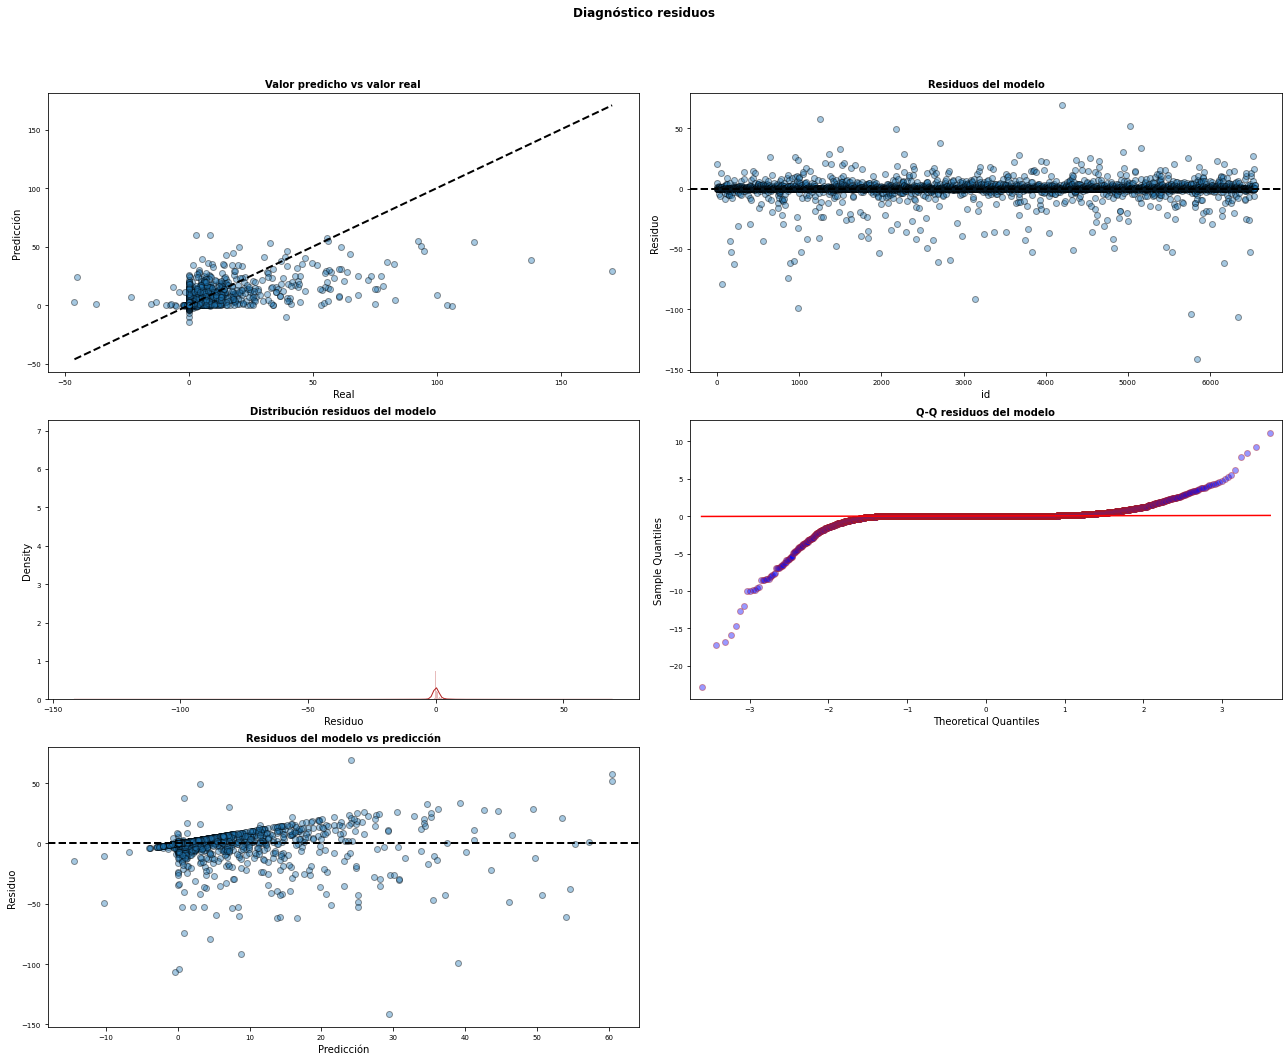

In [ ]:
# Evaluación de residuos
diag_residuos(y_test, X_test, model)